First, I will load the dataset:

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [3]:
#Add in the interest rate DF from csv 

#create new DF that combines the two DFs

#depending on what i find, lets say interest rate data with timestamp. Do we take that timestamp and create a new column for month and year? Or do we try to make a new column on house prices DF that has month combines. 

#call pandas .merge or .join would need to be able to say "where month=month and year=year" or is it easier to have a single MM/YYYY column and lets you join in a single column.

#The interest rate data could change. But it could have changed on any day. Could get that down to the month and get mean/max interest rate for the month.



In the cells below I am conducting my data cleaning, exploratory data analysis and feature engineering.  

In [4]:
house_prices_df.head(10)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [5]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
house_prices_df.describe()


,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [8]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [9]:
house_prices_df.describe().T
#transpose!

,count,mean,std,min,25%,50%,75%,max
id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
mssubclass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
lotfrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
lotarea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
overallqual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
overallcond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
yearbuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
yearremodadd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
masvnrarea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
bsmtfinsf1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [10]:
total_missing = house_prices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Exploratory Data Analysis:

In [11]:


np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Data Cleaning: Here I see a few fields that have nulls: 
lotfrontage, alley, masvnrtype, masvnrarea, fireplacequ, garagetype, garageyrblt, garagefinish, garagequal, garagecond, poolqc, fence, miscfeature. 


In [12]:

house_prices_df.isnull().sum()*100/house_prices_df.count()

#sort descending



id                   0.000000
mssubclass           0.000000
mszoning             0.000000
lotfrontage         21.565362
lotarea              0.000000
street               0.000000
alley             1504.395604
lotshape             0.000000
landcontour          0.000000
utilities            0.000000
lotconfig            0.000000
landslope            0.000000
neighborhood         0.000000
condition1           0.000000
condition2           0.000000
bldgtype             0.000000
housestyle           0.000000
overallqual          0.000000
overallcond          0.000000
yearbuilt            0.000000
yearremodadd         0.000000
roofstyle            0.000000
roofmatl             0.000000
exterior1st          0.000000
exterior2nd          0.000000
masvnrtype           0.550964
masvnrarea           0.550964
exterqual            0.000000
extercond            0.000000
foundation           0.000000
                     ...     
bedroomabvgr         0.000000
kitchenabvgr         0.000000
kitchenqua

In [13]:
house_prices_df.isnull()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
5,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
7,False,False,False,True,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
9,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False


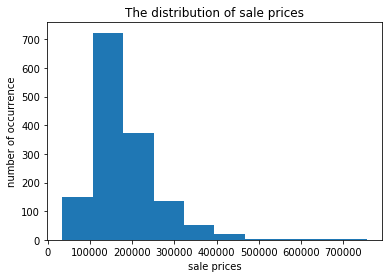

In [14]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

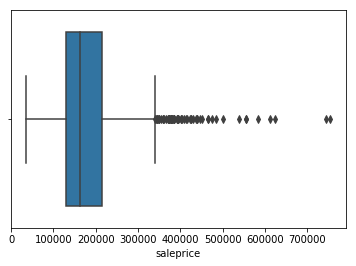

In [15]:

import seaborn as sns
sns.boxplot(x=house_prices_df['saleprice'])


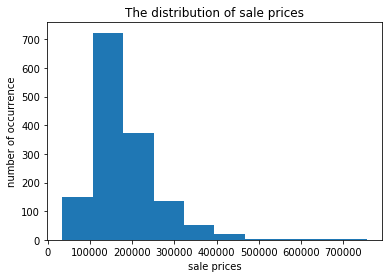

In [16]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

#use distplot has three different plots in the same frame, histogram, 
#kernel density estimate a smooth curve it determines from the data, rug plot 
#adds a line on the X axis for eery data point. 
#Gives you a sense of where the individual values are. 

In [17]:
from scipy import stats
import numpy as np

Q1 = house_prices_df.quantile(0.25)
Q3 = house_prices_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


id                 729.50
mssubclass          50.00
lotfrontage         21.00
lotarea           4048.00
overallqual          2.00
overallcond          1.00
yearbuilt           46.00
yearremodadd        37.00
masvnrarea         166.00
bsmtfinsf1         712.25
bsmtfinsf2           0.00
bsmtunfsf          585.00
totalbsmtsf        502.50
firstflrsf         509.25
secondflrsf        728.00
lowqualfinsf         0.00
grlivarea          647.25
bsmtfullbath         1.00
bsmthalfbath         0.00
fullbath             1.00
halfbath             1.00
bedroomabvgr         1.00
kitchenabvgr         0.00
totrmsabvgrd         2.00
fireplaces           1.00
garageyrblt         41.00
garagecars           1.00
garagearea         241.50
wooddecksf         168.00
openporchsf         68.00
enclosedporch        0.00
threessnporch        0.00
screenporch          0.00
poolarea             0.00
miscval              0.00
mosold               3.00
yrsold               2.00
saleprice        84025.00
dtype: float

Feature engineering:


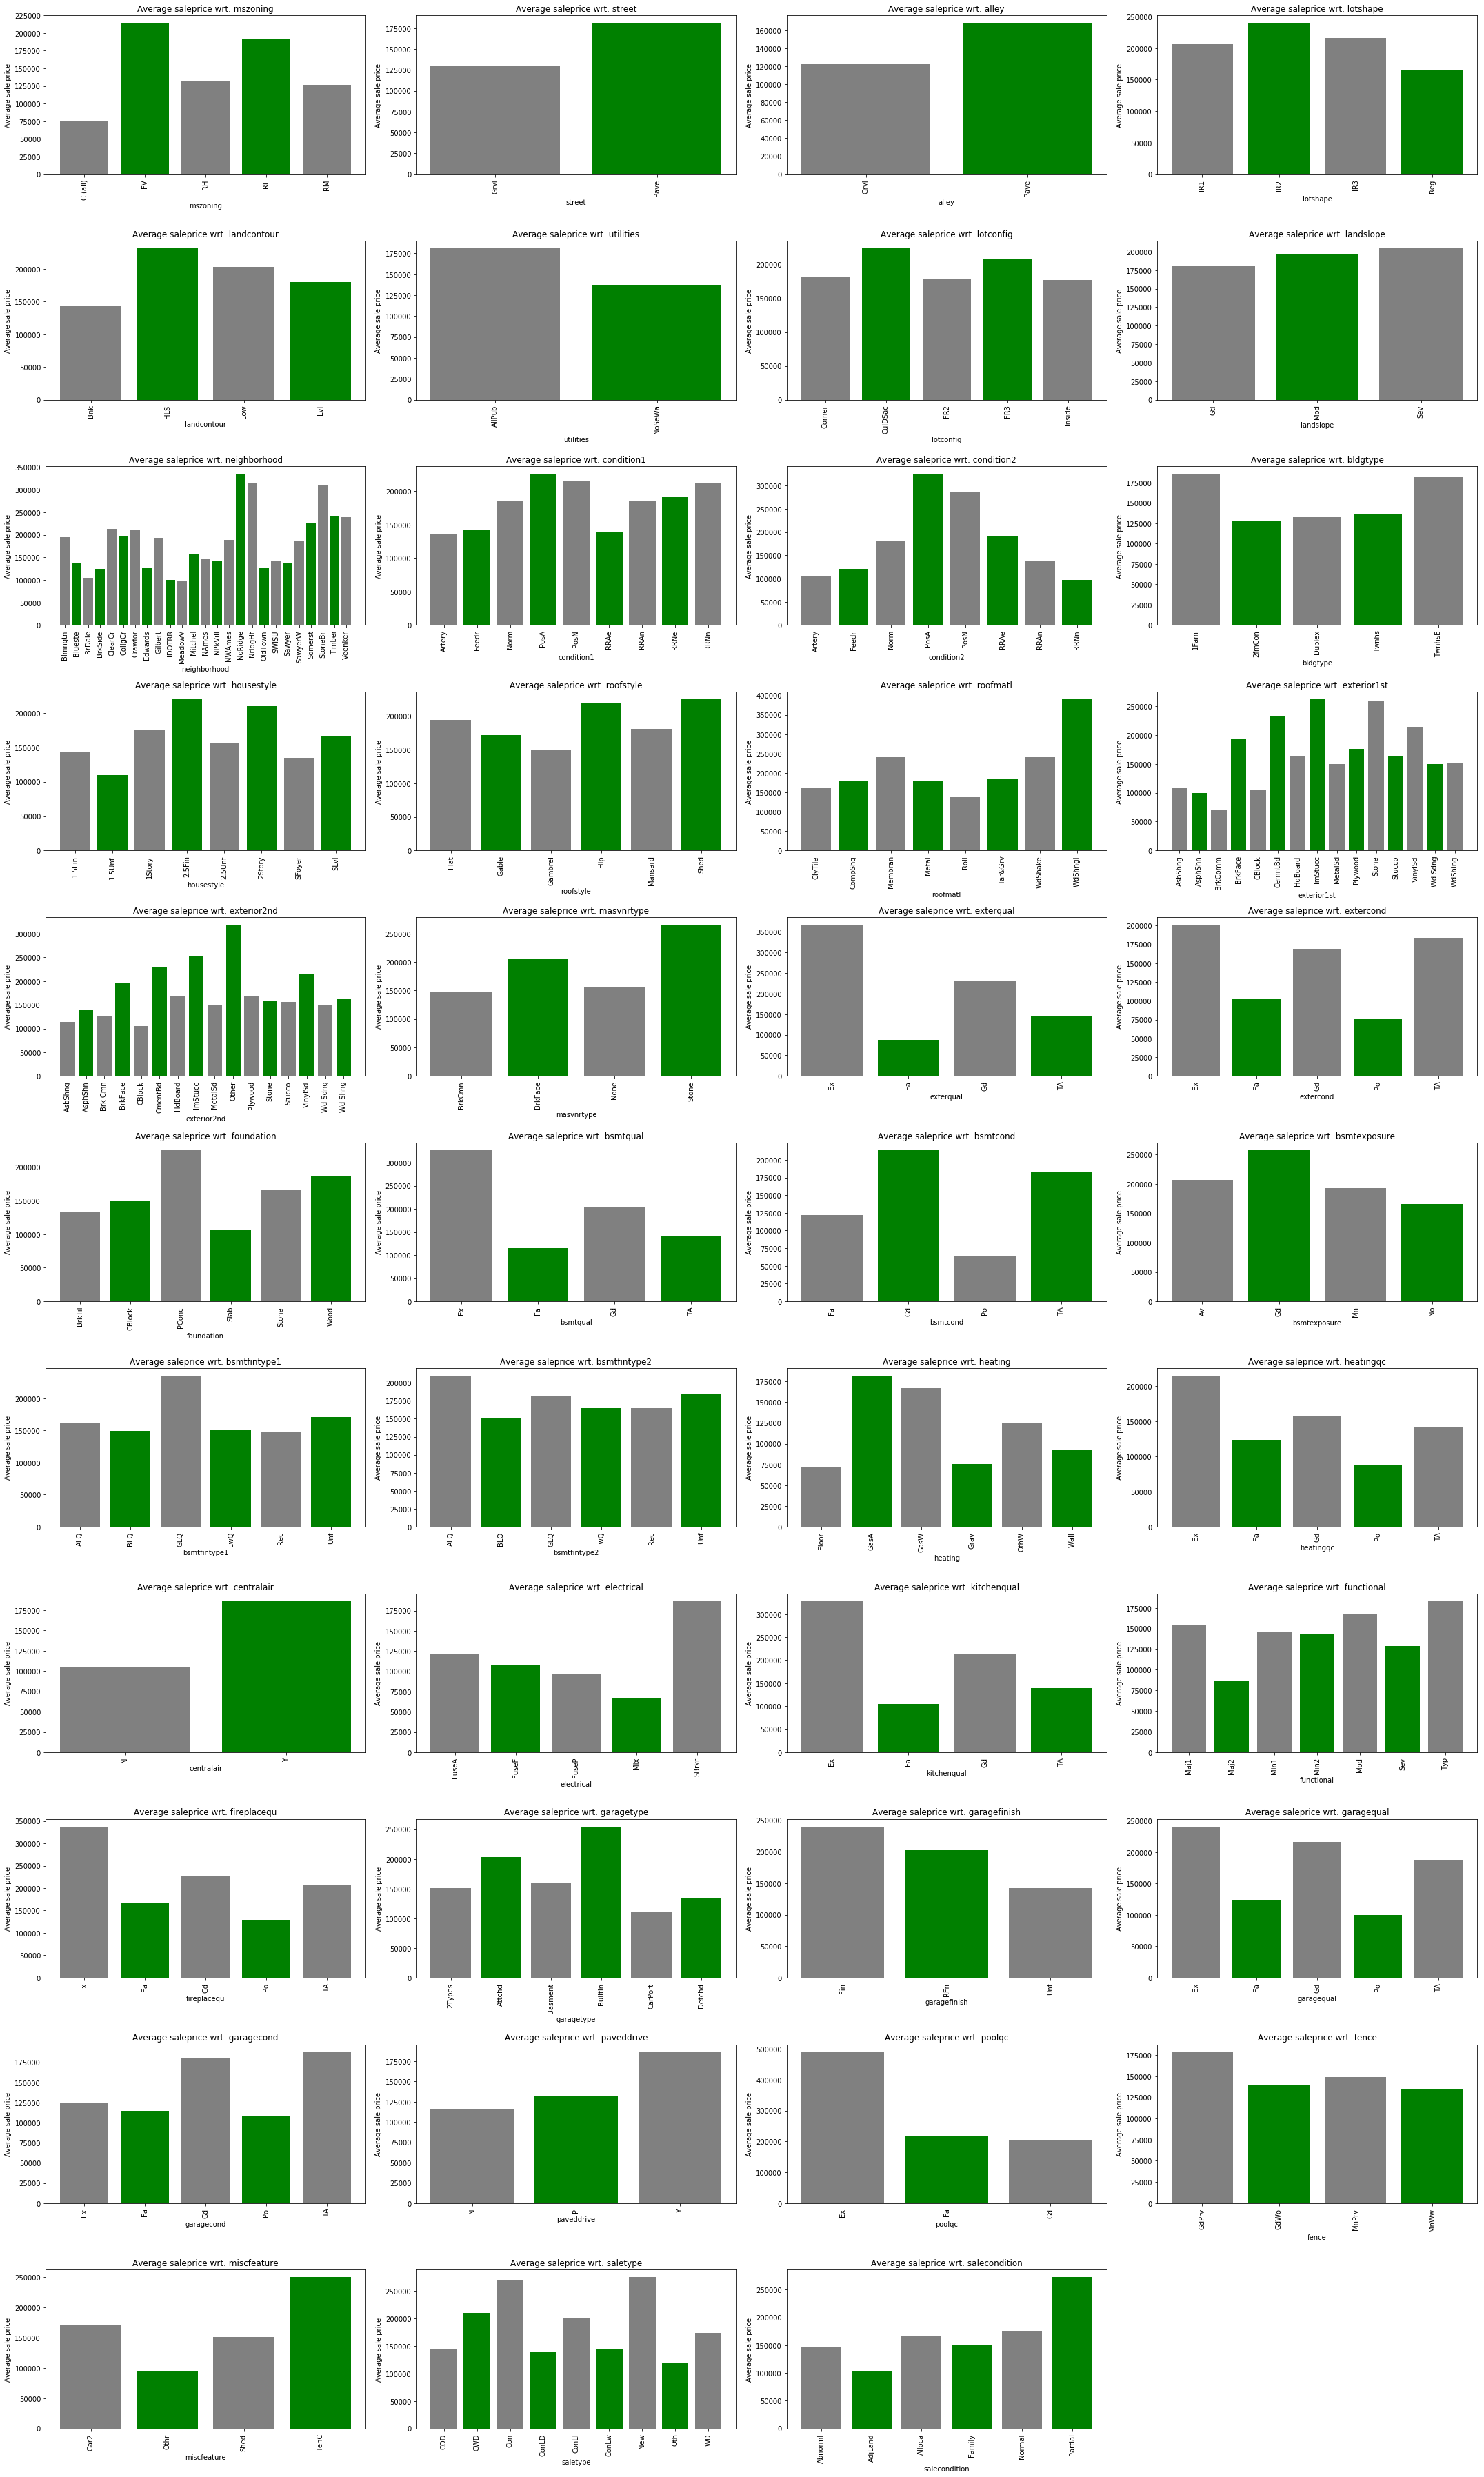

In [18]:

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [19]:
house_prices_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
bsmtfinsf1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [33]:
house_prices_df[house_prices_df.columns[1:]].corr()['saleprice'][:]



mssubclass      -0.084284
lotfrontage      0.351799
lotarea          0.263843
overallqual      0.790982
overallcond     -0.077856
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.477493
bsmtfinsf1       0.386420
bsmtfinsf2      -0.011378
bsmtunfsf        0.214479
totalbsmtsf      0.613581
firstflrsf       0.605852
secondflrsf      0.319334
lowqualfinsf    -0.025606
grlivarea        0.708624
bsmtfullbath     0.227122
bsmthalfbath    -0.016844
fullbath         0.560664
halfbath         0.284108
bedroomabvgr     0.168213
kitchenabvgr    -0.135907
totrmsabvgrd     0.533723
fireplaces       0.466929
garageyrblt      0.486362
garagecars       0.640409
garagearea       0.623431
wooddecksf       0.324413
openporchsf      0.315856
enclosedporch   -0.128578
threessnporch    0.044584
screenporch      0.111447
poolarea         0.092404
miscval         -0.021190
mosold           0.046432
yrsold          -0.028923
saleprice        1.000000
Name: saleprice, dtype: float64

Based on the feature engineering done above, I have deduced the highest correlated variables impacting saleprice below are: 

overallqual      0.790982<br>
garagecars       0.640409<br>
garagearea       0.623431<br>
totalbsmtsf      0.613581<br>
firstflrsf       0.605852<br>
fullbath         0.560664<br>
yearbuilt        0.522897<br>
yearremodadd     0.507101<br>

These are the 8 variables that I found most impactful to sale prices based on the .corr list below as well as other data exploration steps done above. For this reason I will be using these variables in my model preparations further in this challenge.

In [20]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

OLS model:

I will use these variables above for the model for regression
and split my data into train and test sets where 20% of the data 
resides in the test set.

In [21]:
for col in house_prices_df.columns: 
    print(col)
    

#overallqual 0.790982
#garagecars 0.640409
#garagearea 0.623431
#totalbsmtsf 0.613581
#firstflrsf 0.605852
#fullbath 0.560664
#yearbuilt 0.522897
#yearremodadd 0.507101

id
mssubclass
mszoning
lotfrontage
lotarea
street
alley
lotshape
landcontour
utilities
lotconfig
landslope
neighborhood
condition1
condition2
bldgtype
housestyle
overallqual
overallcond
yearbuilt
yearremodadd
roofstyle
roofmatl
exterior1st
exterior2nd
masvnrtype
masvnrarea
exterqual
extercond
foundation
bsmtqual
bsmtcond
bsmtexposure
bsmtfintype1
bsmtfinsf1
bsmtfintype2
bsmtfinsf2
bsmtunfsf
totalbsmtsf
heating
heatingqc
centralair
electrical
firstflrsf
secondflrsf
lowqualfinsf
grlivarea
bsmtfullbath
bsmthalfbath
fullbath
halfbath
bedroomabvgr
kitchenabvgr
kitchenqual
totrmsabvgrd
functional
fireplaces
fireplacequ
garagetype
garageyrblt
garagefinish
garagecars
garagearea
garagequal
garagecond
paveddrive
wooddecksf
openporchsf
enclosedporch
threessnporch
screenporch
poolarea
poolqc
fence
miscfeature
miscval
mosold
yrsold
saletype
salecondition
saleprice
mszoning_FV
mszoning_RH
mszoning_RL
mszoning_RM
street_Pave


For our OLS test below, our R-squared: 0.955
    
Let's see how we can improve on this score with our other models!

In [22]:

X = house_prices_df[['overallqual', 'garagecars', 'garagearea', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'yearbuilt', 'yearremodadd' ]] 
Y = house_prices_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()
results_TEST = sm.OLS(y_test, X_test).fit()


results.summary()

results_TEST.summary()


#Create a dataframe with the new data I am joining (presumably by month/year and averaging ex: interest rate dataframe) and then create a NEW df where you join those two and then you have a new column list when you create your X, 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     748.1
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          6.38e-186
Time:                        19:11:29   Log-Likelihood:                -3528.2
No. Observations:                 292   AIC:                             7072.
Df Residuals:                     284   BIC:                             7102.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
overallqual    2.46e+04   2573.962      9.559      0.000    1.95e+04    2.97e+04
garagecars    9310.0706   7285.576      1.278      0.202   -5030.509    2.37e+04
garagearea      12.9270     13.471      0.960      0.338     -13.589      39.443
garagearea      12.9270     13.471      0.960      0.338     -13.589      39.443
totalbsmtsf     41.1603     12.711      3.238      0.001      16.141      66.180
firstflrsf      36.1786     13.512      2.678      0.008       9.583      62.774
fullbath      1.969e+04   5823.247      3.382      0.001    8230.717    3.12e+04
yearbuilt      -56.7214    115.861     -0.490      0.625    -284.776     171.333
yearremodadd    -0.5748    113.447     -0.005      0.996    -223.878     222.728
==============================================================================
Omnibus:                      173.101   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2235.304
Skew:                           2.137   Prob(JB):                         0.00
Kurtosis:                      15.863   Cond. No.                     3.94e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.03e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

For our Ridge Regression test below, our R-squared: 0.7330 which isnt great.

Let's see how we can improve on this or our previous OLS score of 0.955 with our other models!

In [23]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge() 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7330911619681695
-----Test set statistics-----
R-squared of the model on the test set is: 0.7205049205648382
Mean absolute error of the prediction is: 28482.427500440852
Mean squared error of the prediction is: 1876447254.8847947
Root mean squared error of the prediction is: 43317.97842564672
Mean absolute percentage error of the prediction is: 16.931146758633766


For our Lasso Regression test below, our R-squared: 0.7330

Let's see how we can improve on this or our previous OLS score of 0.955 with our other models!

In [24]:
from sklearn.linear_model import Lasso

lassoregr = Lasso() 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7330914206569882
-----Test set statistics-----
R-squared of the model on the test set is: 0.7204618492991668
Mean absolute error of the prediction is: 28490.44561303151
Mean squared error of the prediction is: 1876736422.6168242
Root mean squared error of the prediction is: 43321.31603052733
Mean absolute percentage error of the prediction is: 16.938451992346433


For our ElasticNet Regression test below, our R-squared: 0.7129

Let's see how we can improve on this or our previous OLS score of 0.955 with our other models!

In [25]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet() 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7129632808809698
-----Test set statistics-----
R-squared of the model on the test set is: 0.7194110934594541
Mean absolute error of the prediction is: 27377.557354692453
Mean squared error of the prediction is: 1883790886.3840132
Root mean squared error of the prediction is: 43402.65989987265
Mean absolute percentage error of the prediction is: 15.5233105936689


Finally we will compare our results with a Linear Regression test below.
Here, our R-squared: 0.73309 which is still below our OLS score of 0.955 which ultimately makes OLS our best performing model! 


In [26]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7330914225684109
-----Test set statistics-----
R-squared of the model in test set is: 0.7204594589232483
Mean absolute error of the prediction is: 28490.892710275322
Mean squared error of the prediction is: 1876752470.8933785
Root mean squared error of the prediction is: 43321.50125391984
Mean absolute percentage error of the prediction is: 16.938876105588914


So far, I have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model

I am making predictions here:


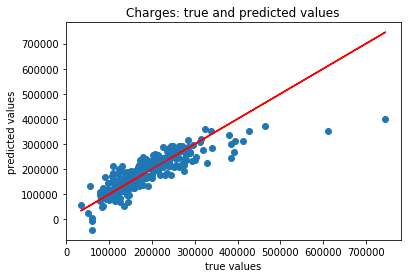

Mean absolute error of the prediction is: 29140.971677185826
Mean squared error of the prediction is: 1923976182.445751
Root mean squared error of the prediction is: 43863.15290133338
Mean absolute percentage error of the prediction is: 17.585025699618022


In [27]:

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In [28]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     520.9
Date:                Sat, 21 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:11:53   Log-Likelihood:                 463.99
No. Observations:                1168   AIC:                            -904.0
Df Residuals:                    1156   BIC:                            -843.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.9162      0.102     97.518      0.000       9.717      10.116
overallqual     0.1893      0.009     20.123      0.000       0.171       0.208
grlivarea     9.58e-05   1.89e-05      5.074      0.000    5.88e-05       0.000
garagecars      0.0779      0.015      5.244      0.000       0.049       0.107
garagearea      0.0001   5.04e-05      2.132      0.033    8.57e-06       0.000
totalsf         0.0003   2.58e-05     11.139      0.000       0.000       0.000
int_over_sf -2.572e-05   3.02e-06     -8.526      0.000   -3.16e-05   -1.98e-05
mszoning_FV     0.3911      0.065      6.055      0.000       0.264       0.518
mszoning_RH     0.2650      0.074      3.593      0.000       0.120       0.410
mszoning_RL     0.3879      0.060      6.481      0.000       0.270       0.505
mszoning_RM     0.2155      0.061      3.556      0.000       0.097       0.334
street_Pave    -0.0556      0.075     -0.744      0.457      -0.202       0.091
==============================================================================
Omnibus:                      350.711   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2714.386
Skew:                          -1.167   Prob(JB):                         0.00
Kurtosis:                      10.094   Cond. No.                     5.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     651.8
Date:                Sat, 21 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:11:56   Log-Likelihood:                 570.75
No. Observations:                1460   AIC:                            -1117.
Df Residuals:                    1448   BIC:                            -1054.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8514      0.089    110.698      0.000       9.677      10.026
overallqual     0.1726      0.008     20.699      0.000       0.156       0.189
grlivarea    8.311e-05   1.72e-05      4.839      0.000    4.94e-05       0.000
garagecars      0.0818      0.013      6.307      0.000       0.056       0.107
garagearea   9.684e-05   4.51e-05      2.149      0.032    8.45e-06       0.000
totalsf         0.0003   2.33e-05     11.473      0.000       0.000       0.000
int_over_sf -2.064e-05   2.72e-06     -7.583      0.000    -2.6e-05   -1.53e-05
mszoning_FV     0.4920      0.059      8.344      0.000       0.376       0.608
mszoning_RH     0.3814      0.068      5.597      0.000       0.248       0.515
mszoning_RL     0.4844      0.055      8.845      0.000       0.377       0.592
mszoning_RM     0.3255      0.055      5.876      0.000       0.217       0.434
street_Pave    -0.0010      0.070     -0.014      0.989      -0.138       0.136
==============================================================================
Omnibus:                      489.548   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5085.468
Skew:                          -1.254   Prob(JB):                         0.00
Kurtosis:                      11.793   Cond. No.                     5.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [31]:


lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8321322553132751
-----Test set statistics-----
R-squared of the model in test set is: 0.8249302330916437
Mean absolute error of the prediction is: 0.12570372872861554
Mean squared error of the prediction is: 0.029192121871356887
Root mean squared error of the prediction is: 0.17085702172096084
Mean absolute percentage error of the prediction is: 1.050357766782362


So far, I have only used the features in the dataset, however, house prices can be affected by many factors like economic activity the interest rates at the time they are sold. 

I've found a data set with interest rates for each year in the housing dataset which I can easily integrate. I have added this data onto GitHub where I can easily access it.


In [33]:



import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/irenebratsis/Thinkful/master/data_csv.csv')
print(df)


     Country Name Country Code  Year      Value
0     Afghanistan          AFG  2008  12.466734
1     Afghanistan          AFG  2012   6.181851
2     Afghanistan          AFG  2013  10.783102
3     Afghanistan          AFG  2014  14.318935
4     Afghanistan          AFG  2015  12.269584
5     Afghanistan          AFG  2016   9.395270
6         Albania          ALB  1992 -65.516430
7         Albania          ALB  1993 -39.682574
8         Albania          ALB  1994 -10.656120
9         Albania          ALB  1995  13.333572
10        Albania          ALB  1996 -12.257787
11        Albania          ALB  1999  19.778401
12        Albania          ALB  2000  17.427378
13        Albania          ALB  2001  15.799378
14        Albania          ALB  2002  12.590082
15        Albania          ALB  2003   8.437210
16        Albania          ALB  2004   9.187872
17        Albania          ALB  2005  10.186980
18        Albania          ALB  2006   9.974964
19        Albania          ALB  2007  10

In [34]:
df = df[df['Country Code'] == "USA"]

print (df)



       Country Name Country Code  Year     Value
3806  United States          USA  1961  3.107885
3807  United States          USA  1962  3.215346
3808  United States          USA  1963  3.374882
3809  United States          USA  1964  2.951669
3810  United States          USA  1965  2.565913
3811  United States          USA  1966  2.649421
3812  United States          USA  1967  2.406227
3813  United States          USA  1968  1.863911
3814  United States          USA  1969  2.851773
3815  United States          USA  1970  5.575265
3816  United States          USA  1971  0.614434
3817  United States          USA  1972  0.880974
3818  United States          USA  1973  2.446488
3819  United States          USA  1974  1.665644
3820  United States          USA  1975 -1.280346
3821  United States          USA  1976  1.280760
3822  United States          USA  1977  0.584917
3823  United States          USA  1978  1.901859
3824  United States          USA  1979  4.073622
3825  United States 

In [38]:
df_new = pd.merge(df, house_prices_df, how='inner', left_on='Year', right_on='yrsold')

print (df_new)
    

       Country Name Country Code  Year     Value    id  mssubclass mszoning  \
0     United States          USA  2006  4.739620     4          70       RL   
1     United States          USA  2006  4.739620    12          60       RL   
2     United States          USA  2006  4.739620    18          90       RL   
3     United States          USA  2006  4.739620    21          60       RL   
4     United States          USA  2006  4.739620    29          20       RL   
5     United States          USA  2006  4.739620    36          60       RL   
6     United States          USA  2006  4.739620    41          20       RL   
7     United States          USA  2006  4.739620    45          20       RL   
8     United States          USA  2006  4.739620    52          50       RM   
9     United States          USA  2006  4.739620    54          20       RL   
10    United States          USA  2006  4.739620    58          60       RL   
11    United States          USA  2006  4.739620    

I will integrate these factors into my model and assess the prediction performance of my model. 

Since OLS was the best performing model, I will use this one with the new appended data. 



In [39]:
X = df_new[['overallqual', 'garagecars', 'garagearea', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'yearbuilt', 'yearremodadd', 'Year', 'Value' ]] 
Y = df_new['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()
results_TEST = sm.OLS(y_test, X_test).fit()


results.summary()

results_TEST.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     730.0
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          4.14e-195
Time:                        19:23:54   Log-Likelihood:                -3491.8
No. Observations:                 292   AIC:                             7004.
Df Residuals:                     282   BIC:                             7040.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
overallqual   2.363e+04   2685.848      8.796      0.000    1.83e+04    2.89e+04
garagecars     322.0101   7371.003      0.044      0.965   -1.42e+04    1.48e+04
garagearea      27.6934     12.824      2.159      0.032       2.450      52.937
garagearea      27.6934     12.824      2.159      0.032       2.450      52.937
totalbsmtsf     22.3915      9.473      2.364      0.019       3.746      41.037
firstflrsf      32.3375     10.540      3.068      0.002      11.591      53.084
fullbath      9005.4855   5605.977      1.606      0.109   -2029.387       2e+04
yearbuilt     -100.4525    114.319     -0.879      0.380    -325.480     124.575
yearremodadd   492.7650    158.050      3.118      0.002     181.658     803.872
Year          -420.9288    149.987     -2.806      0.005    -716.165    -125.693
Value          133.3656   1865.570      0.071      0.943   -3538.845    3805.576
==============================================================================
Omnibus:                       50.267   Durbin-Watson:                   2.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.867
Skew:                          -0.002   Prob(JB):                    8.96e-126
Kurtosis:                       9.880   Cond. No.                     9.03e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.28e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So already we do see an improvement in the R-squared from 0.955 the first time we ran the OLS model and this time we have an R-squared of 0.963 which is a marginal improvement. It appears the more data we add to our training set, the better that model performs on our test set. 

